# Data Visualisation

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import scipy as sc
from scipy.stats import uniform, randint

import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
from keras.utils import pad_sequences
from keras.models import Sequential

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


## Data import

### Import and split pp file

In [23]:
def import_pp_v1(filename):
    column_names = ['timestamp','user_id','record_id','value','alt_value']
    
    pp_file = pd.read_csv(filename, header=None, usecols=[0,1,2,3,4], names=column_names)
    
    pp_segments = {}
    for record_id, group in pp_file.groupby('record_id'):
        pp_segments[record_id] = group.reset_index(drop=True)
        
    print(str(len(pp_segments)) + ' segments found in PP file.')
        
    return pp_segments

In [24]:
def import_pp_v2(filename):
    column_names = ['timestamp','user_id','value','alt_value']
    pp_file = pd.read_csv(filename, header=None, usecols=[0,1,2,3], names=column_names)

    time_threshold = 1000 * 60 * 2
    
    split_indices = np.where(pp_file['timestamp'].diff().dropna() > time_threshold)[0] + 1
    pp_segments = np.split(pp_file, split_indices)
    
    print(str(len(pp_segments)) + ' segments found in PP file.')
    
    for idx, seg in enumerate(pp_segments):
        print(f"Segment {idx}...")
        seg.reset_index(inplace=True, drop=True)
        print(f"First timestamp: {seg.loc[0, 'timestamp']}")
        print(f"Last timestamp: {seg.loc[seg.index[-1], 'timestamp']}\n")
        print(f"Difference: {seg.loc[seg.index[-1], 'timestamp'] - seg.loc[0, 'timestamp']}\n")

    return pp_segments

### Import and split PPG file

In [25]:
def import_ppg(filename):
    column_names = ['timestamp','user_id','record_id','value','alt_value_1','alt_value_2','alt_value_3']
    dtypes = {'timestamp':object,'value':object}

    ppg_file = pd.read_csv(filename, header=None, usecols=[0,1,2,3,4,5,6], dtype=dtypes, names=column_names)

    ppg_file['value'] = pd.to_numeric(ppg_file['value'], errors='coerce')
    ppg_file['timestamp'] = pd.to_numeric(ppg_file['timestamp'], errors='coerce')

    ppg_file = ppg_file.dropna()
    
    ppg_file['value'] = ppg_file['value'].astype('int64')
    
    ppg_segments = {}
    for record_id, group in ppg_file.groupby('record_id'):
        ppg_segments[record_id] = group.reset_index(drop=True)
        
    print(str(len(ppg_segments)) + ' segments found in PPG file.')
    
    return ppg_segments

### Import and split answers

In [26]:
def import_answers(filename):
    column_names = ['timestamp','user_id','record_id','watching','emotion_rating','fatigue_rating']

    answers_file = pd.read_csv(filename, header=None, names=column_names)

    answers_segments = {}
    for record_id, group in answers_file.groupby('record_id'):
        answers_segments[record_id] = group.reset_index(drop=True)
            
    print(str(len(answers_segments)) + ' segments found in answers file.')
    
    return answers_segments

### Import and split heart beat sensor

In [27]:
def import_heartbeat(filename):
    column_names = ['timestamp','user_id','record_id','certainty']
    
    heartbeat_file = pd.read_csv(filename, header=None, names=column_names)
    
    heartbeat_segments = {}
    for record_id, group in heartbeat_file.groupby('record_id'):
        heartbeat_segments[record_id] = group.reset_index(drop=True)
            
    print(str(len(heartbeat_segments)) + ' segments found in heartbeat file.')
    
    return heartbeat_segments

## Derive data from files

In [28]:
def get_common_record_id(pp_segments, answers_segments):
    common_record_id = set(pp_segments.keys())
    common_record_id.intersection_update(answers_segments.keys())
    
    return common_record_id

In [29]:
def normalize_pp_by_person(pp_segments):
    
    user_data = {}
    normalized_pp_segments = copy.deepcopy(pp_segments)
    
    # Gather all pp-intervals by person
    for record_id in pp_segments.keys():

        user_id = pp_segments[record_id]['user_id'][0]

        if user_id in user_data.keys():
            user_data[user_id] = np.append(user_data[user_id], pp_segments[record_id]['value'].values)
        else:
            user_data[user_id] = pp_segments[record_id]['value'].values

    # Get and print mean and stdev of all pp-intervals by person
    user_data = {k: [v.mean(), v.std()] for k,v in user_data.items()}
    
    for user_id in user_data:
        print(f"user_id: {user_id}\tmean/stdev: {user_data[user_id]}")
    
    # Use mean and stdev to normalize pp_segments dict
    for record_id in normalized_pp_segments.keys():
        user_id = normalized_pp_segments[record_id]['user_id'][0]
        
        value_column = normalized_pp_segments[record_id]['value']
        value_column = (value_column - user_data[user_id][0]) / (user_data[user_id][1])
        
        normalized_pp_segments[record_id]['value'] = value_column
    return normalized_pp_segments

In [30]:
def generate_derived_data(pp_segments, answers_segments, print_information_flag, normalized_data_flag):
    
    columns = [
                'record_id',
                'user_id',
                'mean',
                'sdnn',
                'pnn50',
                'cvrr',
                'periodogram_lhrate',
                'periodogram_lfnorm',
                'periodogram_hfnorm',
                'vector_angle_index',
                'vector_length_index',
                'fractal_dimension',
                'emotion_rating',
                'fatigue_rating'
                ]

    results = pd.DataFrame(columns=columns)
    
    common_record_id = get_common_record_id(pp_segments, answers_segments)            
    print(str(len(common_record_id)) + ' segments with common record ids found.' + '\n')
    
    for record_id in common_record_id: 

        if print_information_flag:
            # Basic analysis of sampling frequency
            samples_amount = len(pp_segments[record_id])
            time_interval = pp_segments[record_id]['timestamp'].iloc[-1] - pp_segments[record_id]['timestamp'].iloc[0]
            sampling_freq = 1_000_000_000 / pp_segments[record_id]['timestamp'].diff().dropna().mean()
            alt_sampling_freq = samples_amount / time_interval * 1_000_000_000

            print(f"Amount of samples: {samples_amount}")
            print(f"Timeinterval: {sampling_freq}")
            print(f"Detected sampling frequency from mean period: {sampling_freq}")
            print(f"Detected sampling frequency from total timeinterval and amount of samples: {alt_sampling_freq}\n")

        # Mean (ms)
        mean = pp_segments[record_id]['value'].mean()

        # SDNN Index (ms*ms)
        adjacent_differences = pp_segments[record_id]['value'].diff().dropna().abs()
        sdnn = adjacent_differences.std()

        # PNN50 (%)
        threshold = 0.05 if normalized_data_flag else 50
        pnn50 = len(adjacent_differences[adjacent_differences > threshold]) / len(adjacent_differences)

        # CVrr / HRV Coefficient, ratio of stddev and mean
        cvrr = pp_segments[record_id]['value'].std() / pp_segments[record_id]['value'].mean()

        # Periodogram                
        # Expected values are: 
            # LF: 20-150 ms^2
            # HF: 50-250 ms^2
            # LF/HF ratio: 0.5/2
        # According to task force of european society of cardiology and the north american society of pacing and electrophysiology
        # This function because of the integrated support for uneven sampling
        # Another option was estimating the values
        
        freqs = np.linspace(0.04, 0.4, 100000)
        psd = sc.signal.lombscargle(pp_segments[record_id]['timestamp']/1_000_000,pp_segments[record_id]['value'],freqs)
        
        total_power = np.trapz(psd, freqs)
        hf_power = np.trapz(psd[(freqs >= 0.15) & (freqs <= 0.4)], freqs[(freqs >= 0.15) & (freqs <= 0.4)])
        lf_power = np.trapz(psd[(freqs >= 0.04) & (freqs <= 0.15)], freqs[(freqs >= 0.04) & (freqs <= 0.15)])

        hf_norm = (hf_power / total_power) * 100
        lf_norm = (lf_power / total_power) * 100
        lh_rate = lf_power / hf_power
        
        # Poincaré Scatterplot --> https://en.wikipedia.org/wiki/Poincar%C3%A9_plot
        shortened_adjacent_differences = adjacent_differences[:-1].values
        adjacent_differences_shift_left = adjacent_differences[1:].values

        if print_information_flag:
            plt.scatter(shortened_adjacent_differences, adjacent_differences_shift_left)
            plt.xlabel('Current R-R interval')
            plt.ylabel('Next R-R interval')
            plt.show()
        
        # Vector Angle Index, reglects changes in the fast component
        vector_angle_index = np.mean(
            np.abs(
                np.degrees(
                    np.arctan(
                        adjacent_differences_shift_left / shortened_adjacent_differences
                    )
                ) - 45
            )
        )       
                   
        # Vector Length Index, reflects the slow changing components of HRV (ms)
        adjacent_differences_combined = np.column_stack((shortened_adjacent_differences, adjacent_differences_shift_left))        
        vector_lengths = np.linalg.norm(adjacent_differences_combined, axis=1)

        vector_length_index = np.sqrt(np.mean(((vector_lengths - np.mean(vector_lengths)) ** 2)))
        
        # Fractal Dimension
        max_timestamp = pp_segments[record_id]['timestamp'].iloc[-1]
        min_value = np.min(pp_segments[record_id]['value'])
        max_value = np.max(pp_segments[record_id]['value'])
        
        normalized_timestamp = pp_segments[record_id]['timestamp'] / max_value
        normalized_value = (pp_segments[record_id]['value'] - min_value) / (max_value - min_value)
        
        timestamp_value_combined = np.column_stack((normalized_timestamp, normalized_value))
                
        unit_square = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])
        timestamp_value_combined_mapped = np.matmul(timestamp_value_combined, unit_square.T)
        
        curve_length = np.sum(np.sqrt(np.sum(np.diff(timestamp_value_combined_mapped, axis=0)**2, axis=1)))
        fractal_dimension = 1 + np.log(curve_length) / np.log(2 * (len(pp_segments[record_id]['value'])-1))
                
        # Answers
        emotion_rating = answers_segments[record_id].iloc[0]['emotion_rating'].astype(int)
        fatigue_rating = answers_segments[record_id].iloc[0]['fatigue_rating'].astype(int)
        
        new_row = [record_id,answers_segments[record_id]['user_id'][0],mean,sdnn,pnn50,cvrr,lh_rate,lf_norm,hf_norm,vector_angle_index,vector_length_index,fractal_dimension,emotion_rating,fatigue_rating]
        results.loc[len(results)] = new_row

    return results

## Data analysis

In [31]:
def display_ppg_data(ppg_segments, heartbeat_segments):
    
    ppg_segments = {k: v for k, v in ppg_segments.items() if k in [1]}
        
    for seg in ppg_segments.values():
    
        seg['timestamp'] = (seg['timestamp'] - seg['timestamp'].iloc[0]) / 1_000_000_000

        plt.plot(seg['timestamp'],seg['value'])
        plt.xlabel('Time')
        plt.ylabel('PPG Data')
        plt.show()

In [32]:
pp_segments = import_pp_v1('../Data/Induced Dump/Combined Results/ppSensor.csv')
ppg_segments = import_ppg('../Data/Induced Dump/Combined Results/ppgSensor.csv')
answers_segments = import_answers('../Data/Induced Dump/Combined Results/evalAnswers.csv')

pp_segments.update(import_pp_v1('../Data/Dump 2/ppSensor.csv'))
ppg_segments.update(import_ppg('../Data/Dump 2/ppgSensor.csv'))
answers_segments.update(import_answers('../Data/Dump 2/evalAnswers.csv'))

pp_segments.update(import_pp_v1('../Data/Dump 3/ppSensor.csv'))
ppg_segments.update(import_ppg('../Data/Dump 3/ppgSensor.csv'))
answers_segments.update(import_answers('../Data/Dump 3/evalAnswers.csv'))

pp_segments = normalize_pp_by_person(pp_segments)

15 segments found in PP file.
15 segments found in PPG file.
15 segments found in answers file.
36 segments found in PP file.
37 segments found in PPG file.
32 segments found in answers file.
15 segments found in PP file.
15 segments found in PPG file.
15 segments found in answers file.
user_id: 1	mean/stdev: [889.7741935483871, 205.83131359588535]
user_id: 2	mean/stdev: [844.5428147520136, 211.07717481664304]
user_id: 3	mean/stdev: [1174.1342835708926, 262.22198289714237]


In [ ]:
results = generate_derived_data(pp_segments, answers_segments, False, True)

sns.heatmap(results.corr(), annot=True)
sns.pairplot(results)
plt.show()

results.head()
# corr matrix can only show non linear relationships

62 segments with common record ids found.



C:\Users\vande\AppData\Local\Temp\ipykernel_19472\2242985440.py:88: RuntimeWarning: divide by zero encountered in divide
  adjacent_differences_shift_left / shortened_adjacent_differences
C:\Users\vande\AppData\Local\Temp\ipykernel_19472\2242985440.py:88: RuntimeWarning: divide by zero encountered in divide
  adjacent_differences_shift_left / shortened_adjacent_differences
C:\Users\vande\AppData\Local\Temp\ipykernel_19472\2242985440.py:88: RuntimeWarning: divide by zero encountered in divide
  adjacent_differences_shift_left / shortened_adjacent_differences
C:\Users\vande\AppData\Local\Temp\ipykernel_19472\2242985440.py:88: RuntimeWarning: divide by zero encountered in divide
  adjacent_differences_shift_left / shortened_adjacent_differences
C:\Users\vande\AppData\Local\Temp\ipykernel_19472\2242985440.py:88: RuntimeWarning: divide by zero encountered in divide
  adjacent_differences_shift_left / shortened_adjacent_differences
C:\Users\vande\AppData\Local\Temp\ipykernel_19472\2242985440

In [ ]:
counts = np.bincount(results['rating'])

for i in range(len(counts)):
    print("Value", i, "occurs", counts[i], "times")

## Models Emotion Detection

### Regression

#### Extractor

In [14]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#print(results['rating'])

reg_input_data = results.drop(['record_id','user_id','rating'], axis=1)
reg_target = results['rating']

extraction_index = 17
extracted_row = reg_input_data.iloc[extraction_index].values

#reg_input_data = reg_input_data.drop(extraction_index, axis=0).values
#reg_target = reg_target.drop(extraction_index, axis=0)['rating']

#### Sampler

In [15]:
sampler = RandomOverSampler()
reg_input_data, reg_target = sampler.fit_resample(reg_input_data, reg_target)

counts = np.bincount(reg_target)
for i in range(len(counts)):
    print("Value", i, "occurs", counts[i], "times")

Value 0 occurs 37 times
Value 1 occurs 0 times
Value 2 occurs 37 times
Value 3 occurs 37 times
Value 4 occurs 37 times


#### Model

In [16]:
param_dist = {
    'polynomialfeatures__degree': randint(1, 10),
    'lasso__alpha': uniform(0.01, 300),
}

pipeline = make_pipeline(
    PolynomialFeatures(),
    Lasso(),
)

rand_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    cv=KFold(shuffle=True),
    n_jobs=-1,
    n_iter=300,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    verbose=1,
)

rand_search.fit(reg_input_data, reg_target)

print('Best score:', -rand_search.best_score_)
print('Best params:', rand_search.best_params_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best score: 1.3153154377522083
Best params: {'lasso__alpha': 38.75782454544849, 'polynomialfeatures__degree': 3}


C:\Users\vande\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.061e+01, tolerance: 3.238e-02
  model = cd_fast.enet_coordinate_descent(


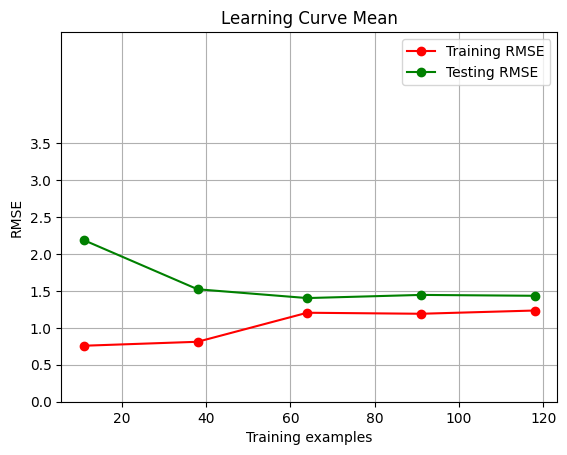

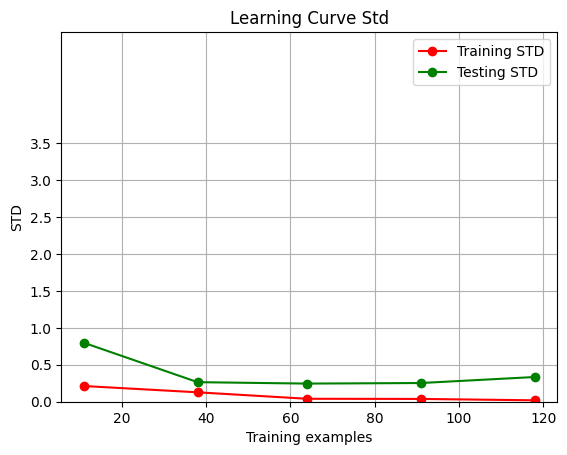

In [21]:
train_sizes, train_scores, test_scores = learning_curve(
    make_pipeline(PolynomialFeatures(degree=3), Lasso(alpha=78.2780870025142, max_iter=20000)),
    reg_input_data, reg_target, 
    cv=KFold(shuffle=True),
    scoring='neg_root_mean_squared_error'
)

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve Mean")
plt.xlabel("Training examples")
plt.ylabel("RMSE")
plt.yticks(np.arange(0, 4, 0.5))
plt.ylim(0, 5)
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training RMSE")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Testing RMSE")

plt.legend(loc="best")
plt.show()

plt.figure()
plt.title("Learning Curve Std")
plt.xlabel("Training examples")
plt.ylabel("STD")
plt.yticks(np.arange(0, 4, 0.5))
plt.ylim(0, 5)
plt.grid()

plt.plot(train_sizes, train_scores_std, 'o-', color="r",
         label="Training STD")
plt.plot(train_sizes, test_scores_std, 'o-', color="g",
         label="Testing STD")

plt.legend(loc="best")
plt.show()

# 1 means that predicted values are on average 1 point off of the actual values

#### Test of extraction

In [18]:
model = LinearRegression()
model.fit(reg_input_data_poly, reg_target)

extracted_row_poly = PolynomialFeatures(degree=1).fit_transform(extracted_row.reshape(1, -1))
predictions = model.predict(extracted_row_poly)

print(predictions)

NameError: name 'reg_input_data_poly' is not defined

### 2 binary classifiers

In [ ]:
# Pos vibes finder

pos_class_input_data = results.drop(['record_id','user_id','rating'], axis=1).values
pos_class_classes = np.where(results['rating'] > 2, 1, 0)

pos_class_input_data, pos_class_classes = sampler.fit_resample(pos_class_input_data, pos_class_classes)

counts = np.bincount(pos_class_classes)
for i in range(len(counts)):
    print("Value", i, "occurs", counts[i], "times")

# Default value for max_iter is 100
pos_lr = LogisticRegression(max_iter=200)

accuracy = cross_val_score(pos_lr, pos_class_input_data, pos_class_classes, cv=KFold(n_splits=5, shuffle=True))
precision = cross_val_score(pos_lr, pos_class_input_data, pos_class_classes, cv=KFold(n_splits=5, shuffle=True), scoring='precision')

# The closer to 0, the better
neg_log_loss = -cross_val_score(pos_lr, pos_class_input_data, pos_class_classes, cv=KFold(n_splits=5, shuffle=True), scoring='neg_log_loss')

print(f"\nAccuracy: {accuracy.mean():.3f} (+/- {accuracy.std() * 2:.3f})")
print(f"Precision: {precision.mean():.3f} (+/- {precision.std() * 2:.3f})")
print(f"Neg log loss: {neg_log_loss.mean():.3f} (+/- {neg_log_loss.std() * 2:.3f})")
print(f"Average confidence level: {1 / np.exp(neg_log_loss.mean()):.3f}")

In [ ]:
# Neg vibes finder

neg_class_input_data = results.drop(['record_id','user_id','rating'], axis=1).values
neg_class_classes = np.where(results['rating'] < 2, 1, 0)

neg_class_input_data, neg_class_classes = sampler.fit_resample(neg_class_input_data, neg_class_classes)

counts = np.bincount(neg_class_classes)
for i in range(len(counts)):
    print("Value", i, "occurs", counts[i], "times")

# Default value for max_iter is 100
neg_lr = LogisticRegression(max_iter=200)

accuracy = cross_val_score(neg_lr, neg_class_input_data, neg_class_classes, cv=KFold(n_splits=5, shuffle=True))
precision = cross_val_score(neg_lr, neg_class_input_data, neg_class_classes, cv=KFold(n_splits=5, shuffle=True), scoring='precision')

# The closer to 0, the better
neg_log_loss = -cross_val_score(neg_lr, neg_class_input_data, neg_class_classes, cv=5, scoring='neg_log_loss')

# Only high because only 3 samples and duplicated in oversampling, overfit encouraged
print(f"\nAccuracy: {accuracy.mean():.3f} (+/- {accuracy.std() * 2:.3f})")
print(f"Precision: {precision.mean():.3f} (+/- {precision.std() * 2:.3f})")
print(f"Neg log loss: {neg_log_loss.mean():.3f} (+/- {neg_log_loss.std() * 2:.3f})")
print(f"Average confidence level: {1 / np.exp(neg_log_loss.mean()):.3f}")

# Results indicate that predictions are generally correct but the model isn't very confident of them

### Softmax Regression

In [ ]:
softmax_class_input_data = results.drop(['record_id','user_id','rating'], axis=1).values
softmax_class_classes = np.where(results['rating'] < 2, 0, results['rating'])
softmax_class_classes = np.where(softmax_class_classes > 2, 1, softmax_class_classes).astype('int64', casting='unsafe')

print("Class 0 is negative\nClass 1 is positive\nClass 2 is neutral\n")

softmax_class_input_data, softmax_class_classes = sampler.fit_resample(softmax_class_input_data, softmax_class_classes)

counts = np.bincount(softmax_class_classes)
for i in range(len(counts)):
    print("Value", i, "occurs", counts[i], "times")
    
# Default value for max_iter is 100
softmax_lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000000000000000)

accuracy = cross_val_score(softmax_lr, softmax_class_input_data, softmax_class_classes, cv=3)

# Average precision across classes
precision = cross_val_score(softmax_lr, softmax_class_input_data, softmax_class_classes, cv=3, scoring='precision_macro')
neg_log_loss = -cross_val_score(neg_lr, softmax_class_input_data, softmax_class_classes, cv=3, scoring='neg_log_loss')

print(f"\nAccuracy: {accuracy.mean():.3f} (+/- {accuracy.std() * 2:.3f})")
print(f"Precision: {precision.mean():.3f} (+/- {precision.std() * 2:.3f})")
print(f"Neg log loss: {neg_log_loss.mean():.3f} (+/- {neg_log_loss.std() * 2:.3f})")
print(f"Average confidence level: {1 / np.exp(neg_log_loss.mean()):.3f}")

### Deep Learning

In [ ]:
def create_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Load data and split into train, validation, and test sets
y = np.where(results['rating'] < 2, 0, results['rating'])
y = np.where(y > 2, 1, y)

common_record_id = get_common_record_id(pp_segments, ppg_segments, answers_segments)
max_length = min([len(ppg_segments[record_id]) for record_id in common_record_id])

X = []
for record_id in common_record_id:
    seg = ppg_segments[record_id]
    if len(seg) > max_length:
        seg = seg[:max_length]
    X.append(seg[['timestamp','value','alt_value_1','alt_value_2','alt_value_3']])
X = np.array(X)

# Convert target labels to categorical format, to one hot encoding
y = to_categorical(y)

# Define the parameters
time_steps = X.shape[1]
features = X.shape[2]
num_classes = y.shape[1]

# Create a KerasClassifier object
estimator = KerasClassifier(model=create_model, epochs=10, batch_size=32, verbose=0)

# Evaluate the model using cross-validation
accuracy = cross_val_score(estimator, X, y, cv=5)
precision = cross_val_score(estimator, X, y, cv=5, scoring='precision_macro')
neg_log_loss = -cross_val_score(estimator, X, y, cv=5, scoring='neg_log_loss')

print(f"\nAccuracy: {accuracy.mean():.3f} (+/- {accuracy.std() * 2:.3f})")
print(f"Precision: {precision.mean():.3f} (+/- {precision.std() * 2:.3f})")
print(f"Neg log loss: {neg_log_loss.mean():.3f} (+/- {neg_log_loss.std() * 2:.3f})")
print(f"Average confidence level: {1 / np.exp(neg_log_loss.mean()):.3f}")